Developed for a workshop ran in to coincide with iUCR . 

This notebook begins with the basics of TEM simulation and then builds up to 4D-STEM simulation and theory

# Setting up a structure

First let's load a structure and look at the atomic coordinates, and the electrostatic potential (ie. the physical quantity which determines how the beam will interact with the structure).

For this workshop we'll be using a structure which consists of a 180 degree domain wall in a burgonite crystal:

Rigby, O. M., et al. "Structure and electronic properties of domain walls and stacking fault defects in prospective photoferroic materials bournonite and enargite." Journal of Applied Physics 132.18 (2022).
https://pubs.aip.org/aip/jap/article/132/18/185001/2837953 

The authors of this work kindly made the structure available in the supplementary materials.

If you've bought less computational firepower then a silicon sample is offered as an alternative. Simply uncomment this line. If you're not sure yet, you can come back to this cell and re-run it if you ever change your mind.

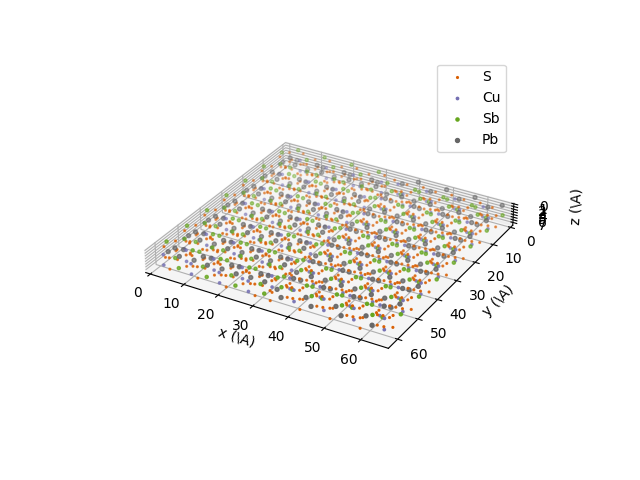

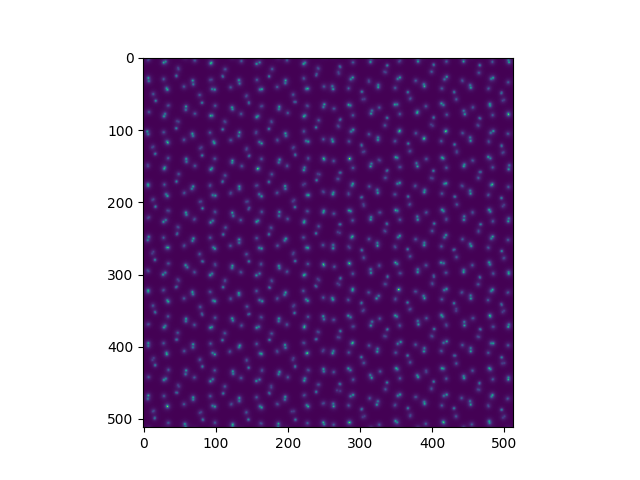

In [1]:
# Import py_multislice, numpy and matplotlib
import pyms
import numpy as np
import matplotlib.pyplot as plt
# for creating a responsive plot
%matplotlib widget

# load the SrTiO3-CeO2 interface (more interesting but might require some computational grunt)
#structure = pyms.structure.fromfile("Structures/SrTiO3_CeO2_interface.xyz",temperature_factor_units='urms',atomic_coordinates='cartesian')
structure = pyms.structure.fromfile("Structures/Bournonite_DW.xyz",temperature_factor_units='urms',atomic_coordinates='fractional').rot90(axes=(0,2)) 

#Create a quickplot of our structure, you can play with scaling using the atomscale parameter
tiling = [7,1]
structure.quickplot(atomscale=0.1,block=False,tiling=tiling + [1])

# Another way of making this notebook run better on a 
pixels = [512,512]

#EXERCISE: rerun this with the tiling keyword argument deleted or set equal to [1,1]
#EXERCISE: rerun this with the keyword argument displacements=False, what do you notice and which do you think 
# is the correct set of potentials to use in a multislice calculation?
potential = structure.make_potential(pixels,tiling=tiling,displacements=True)

# If you're computer is on the underpowered side maybe just stick to something a bit simpler like Si:
#structure = pyms.structure.fromfile("Structures/Si100.xyz",temperature_factor_units='urms',atomic_coordinates='cartesian')
#tiling = [8,8]
#gridsize = np.asarray(tiling)*structure.unitcell[:2]


# If you are using silicon, try tiling=[2,2,2] as a keyword argument here
#structure.quickplot(atomscale=2,tiling=[2,2,2])
# potential = structure.make_potential(pixels,tiling=[5,5])


fig,ax = plt.subplots()
ax.imshow(potential[0].cpu())


If you went with Burgonite, can you see the domain wall? Counter-intuitively it will become more obvious once we start simulating poorer quality TEM images for this structure.

As the name implies, with multislice we have to "slice" the object in the direction of the beam and calculate beam scattering and beam propagation at every slice. If this is done too coarsely then the calculation will not capture the fine details of beam propagation in the sample, if done too finely then our calculation will run too slow. A rule of thumb is to slice the sample every 2 Å. Though for many crystals we can often choose our slices to coincide with planes of atoms so the propagation distances between those planes are exact.

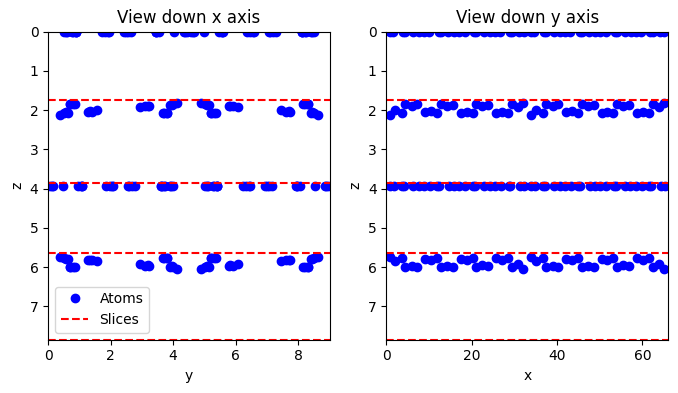

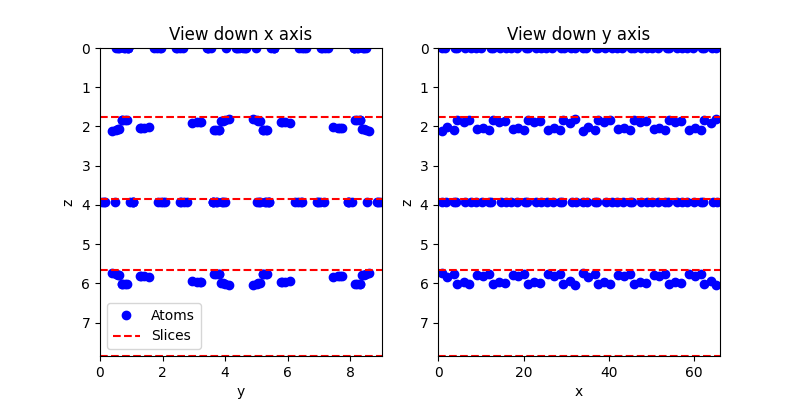

In [2]:

# Even slicing every 2 Angstrom: some minor errors will exhibit in the calculation
slice_thickness = 2
# Work out number of slices per unit cell
nslices = int(np.ceil(structure.unitcell[2]/slice_thickness))

# Calculate even slice thicknesses
slices = np.linspace(1.0/nslices,1.0,nslices)
slices[-1]=1.0

# EXERCISE: Try and do this manualy so that the slices lie exactly under the planes of the atoms
slices = np.asarray([1.75,3.85,5.65,structure.unitcell[2]]) /structure.unitcell[2]

# Generate a slicing figure to visualize what has been done
structure.generate_slicing_figure(slices,show=False)



Lets look at the potentials for each slice using a slider widget

interactive(children=(IntSlider(value=3, description='slice', max=3), Output()), _dom_classes=('widget-interac…

<function __main__.plot_pot(islice)>

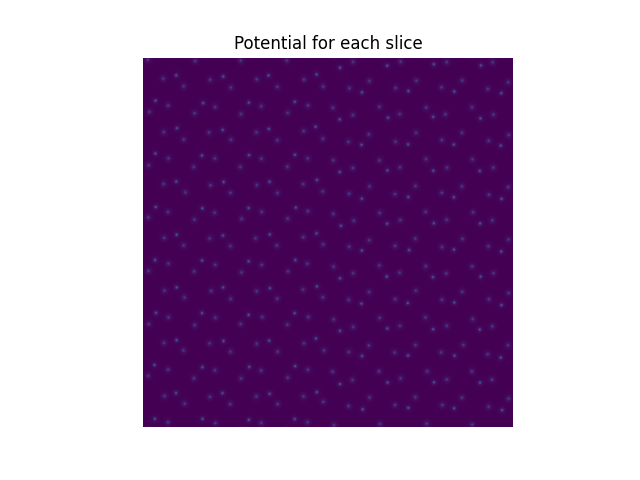

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

potential = structure.make_potential(pixels,tiling=tiling,subslices=slices)
fig,ax= plt.subplots()
im = ax.imshow(potential[0].cpu())
ax.set_axis_off()
ax.set_title("Potential for each slice")


def plot_pot(islice):
    """Function to plot slice islice"""
    im.set_data(potential[islice].cpu())

interact(plot_pot, islice = widgets.IntSlider(value=5,
                                               min=0,
                                               max=len(slices) -1,
                                               step=1, description='slice'))

## Free space propagation

A single iteration of multislice algorithm can be written:

$\Psi(x,y,z+\Delta z) = \mathcal{F}^{-1}\{P\cdot \mathcal{F}\{T(x,y,z)\Psi(x,y,z)\}\}$

$\mathcal{F}$ is the Fourier transform operator, $T(x,y)=e^{i\sigma V(x,y)}$ is the the transmission function and is a function of the electrostatic potential $V(x,y)$ scaled by the interaction constant $\sigma$, and $P(k_x,k_y)=e^{-i\pi \Delta z k^2}$ is the Fresnel free-space propagator. The action of the transmission function $T$ models the interaction of the beam with the sample at every slice and the free space propagator models propagation between slices.

Let's have a look at the propagator:

interactive(children=(FloatSlider(value=10.0, description='dz', max=200.0, step=1.0), Output()), _dom_classes=…

<function __main__.plot_propagator(dz)>

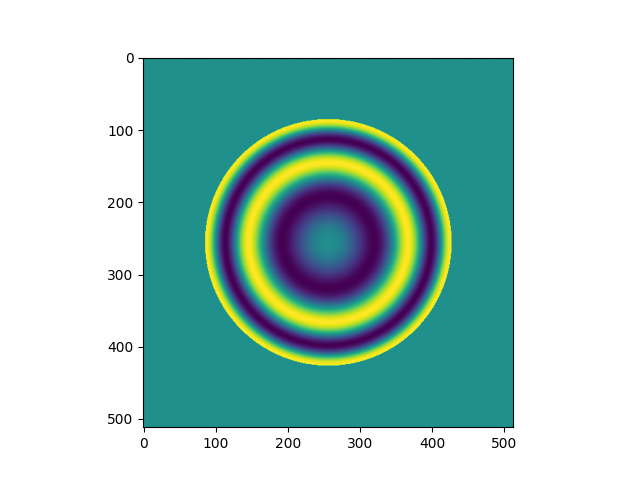

In [4]:
# Number of pixels in our grid
gridpixels=[512,512]
# Size of our grid in Angstrom
gridsize=[40,40,20]
# Beam energy in eV
eV=3e5


fig,ax = plt.subplots()

im = ax.imshow(np.zeros((512,512)),vmin=-1,vmax=1)

def plot_propagator(dz):
    """Function to plot the propagator"""
    gridsize=[40,40,dz]
    propagator = pyms.make_propagators(gridpixels,gridsize,eV)
    # EXERCISE: Why do we need to include the np.fft.fftshift? Try excluding it from this call to imshow
    # QUESTION: What does np.imag do and why do we need to call it to plot the propagator?
    propagator = np.fft.fftshift(np.imag(propagator[0]))
    im.set_data(propagator)
    

interact(plot_propagator, dz = widgets.FloatSlider(value=10.0,
                                               min=0,
                                               max=200,
                                               step=1))


If you've done some experimental TEM before does the above function look familiar? 

If we multiply an electron wave function by it in Fourier space this will propagate the beam a given distance through the vaccuum. Let's look at this:

interactive(children=(IntSlider(value=0, description='islice', max=40), Output()), _dom_classes=('widget-inter…

<function __main__.propagate(islice)>

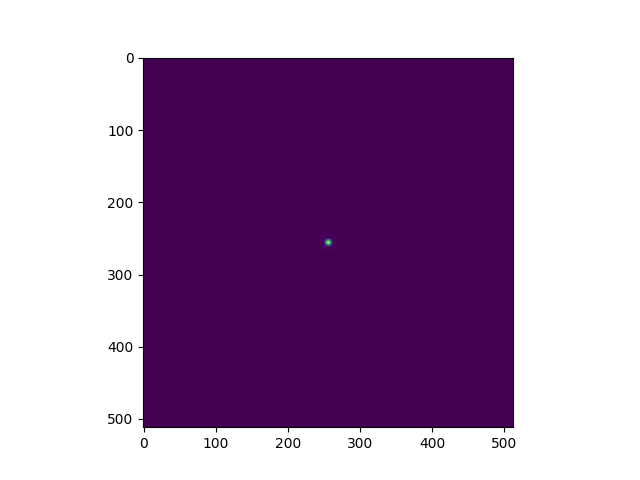

In [5]:
# Focused probe from a 20 mrad probe forming aperture
app = 20
probe = np.fft.fftshift(pyms.focused_probe(gridpixels,gridsize[:2],eV,app,df=0))
gridsize = [20,20,20]

# FFT the probe for propagation
probe = np.fft.fft2(probe)

propagator = pyms.make_propagators(gridpixels,gridsize,eV)

fig, ax = plt.subplots()
im = ax.imshow(np.abs(np.fft.ifft2(probe))**2)

def propagate(islice):
    newprobe = np.abs(np.fft.ifft2(probe*(propagator[0]**islice)))**2
    im.set_data(newprobe)
    im.set_clim(vmin=newprobe.min(),vmax = newprobe.max())
     
     

interact(propagate, islice = widgets.IntSlider(value=0,
                                               min=0,
                                               max=40,
                                               step=1))


Note that for large defocus the probe isn't isn't radially symmetric and has strange looking ripples, why would this be and what might be done to address this?

## Multislice

Now let's add the specimen back in.

Making projected potentials: 100%|████████████████| 5/5 [00:00<00:00, 23.17it/s]


interactive(children=(IntSlider(value=0, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.multislice(n)>

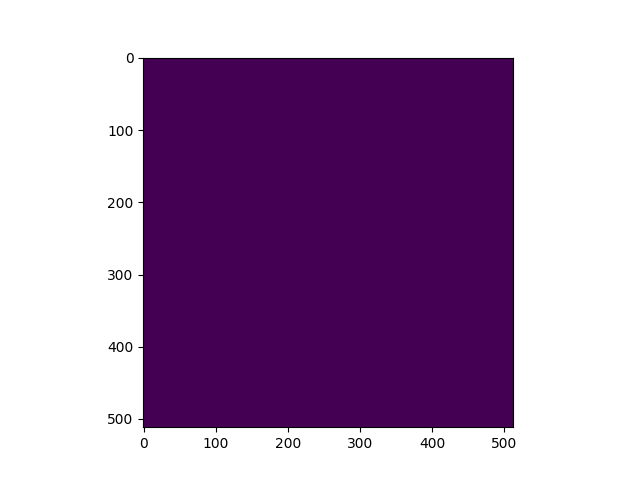

In [6]:
# We can make both propagators and transmission functions using the multislice_precursor convenience function
P,T = pyms.multislice_precursor(structure,gridpixels[:2],eV,subslices=slices,tiling=tiling)

# Lets start with a parrallel beam (a plane wave) for our illumination
gridsize = structure.unitcell[:2]*np.asarray(tiling)
illum = pyms.plane_wave_illumination(gridpixels,gridsize,eV)

# OPTION: Focused probe from a 5 mrad probe forming aperture
#app = 30
#illum = np.fft.fftshift(pyms.focused_probe(gridpixels,structure.unitcell[:2]*np.asarray(tiling),eV,app,df=0))

fig,ax = plt.subplots()
im = ax.imshow(np.abs(illum)**2)

# Lets define a simple multislice function that allows us to turn either tranmission or propagation off by passing 
# None for these quantities
from copy import deepcopy
def multislice(n):
    probe = deepcopy(illum)
    nslices = T.shape[1]
    for i in range(n):
        # Note if you used uneven slicing you'll need to change P -> P[i%nslices]
        probe = np.fft.ifft2(P[i%nslices]*np.fft.fft2(T[0,i%nslices].cpu()*probe))
        #probe = np.fft.ifft2(P*np.fft.fft2(T[0,i%nslices].cpu()*probe))
    probe = np.abs(probe)**2
    im.set_data(probe)
    im.set_clim(vmin=probe.min(),vmax = probe.max())

interact(multislice, n = widgets.IntSlider(value=0,
                                               min=0,
                                               max=100,
                                               step=1))




To a first approximation, as the electron beam propagates through the sample it acquires a phase proportional to the electrostatic potential of the sample.

## Imaging or diffraction?

The result in the previous panel look much sharper that what we are used to in TEM, we call this the "exit-surface" wave since this is the electron wave as it emerges from the specimen in the microscope in the absence of effects such as incoherence. To simulate realistic TEM iamges, we need to consider the effect of the TEM lens. To do this we convolve the result with the lens transfer function including effects such as spherical aberration (C$_s$) and incoherence (which can come from many sources). 

-583.266488093425 12000000.0 300000.0


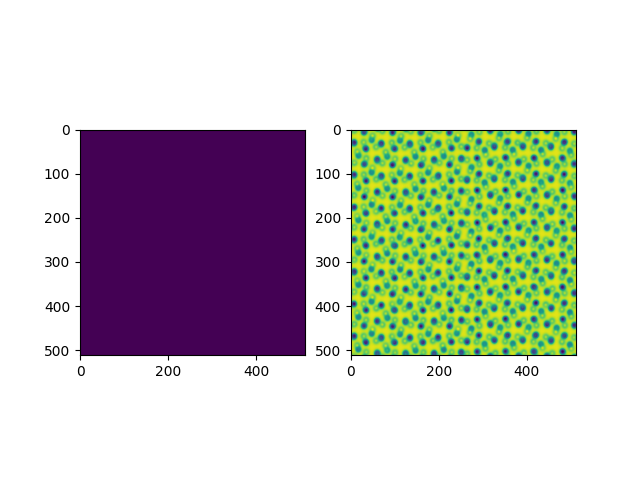

In [7]:
from pyms import aberration
nslices = 5
illum = pyms.plane_wave_illumination(gridpixels,gridsize,eV)
probe = pyms.multislice(illum,nslices,P,T,tiling,output_to_bandwidth_limit=False)

# 2-Fold Astigmatism 
A1 = 0.0

# 3-Fold Astigmatism (should be of the order 1e4 Angstrom to be significant)
A2 = 0e4

# Settings for an uncorrected microscope 
Cs = 1.2e7
#QUESTION: What is Scherzer defocus? Try turning it off
df = 0
df = pyms.Scherzer_defocus(eV,Cs)
print(df,Cs,eV)

#Settings for a corrected microscope
Cs =0.0
df = 0

aberrations = []
aberrations.append(aberration("C10", "C1", "Defocus          ", df, 0.0, 1, 0))
aberrations.append(aberration("C12", "A1", "2-Fold astig.    ", A1, 0.0, 1, 2))
aberrations.append(aberration("C23", "A2", "3-Fold astig.    ", A2, 0.0, 2, 3))
aberrations.append(aberration("C21", "B2", "Axial coma       ", 0.0, 0.0, 2, 1))
aberrations.append(aberration("C30", "C3", "3rd order spher. ", Cs, 0.0, 3, 0))

# Objective aperture in mrad, often this is not used in experiment
obj_app = 30
obj_app = None

# blur
sigma = 0.4
gauss = pyms.utils.Gaussian(sigma,gridpixels,gridsize)

CTF = pyms.make_contrast_transfer_function(gridpixels,gridsize,eV,obj_app,aberrations=aberrations)

fig,ax = plt.subplots(ncols=2)
ax[0].imshow(np.fft.fftshift(np.abs(np.fft.fft2(gauss))*np.imag(CTF)))

ax[1].imshow(np.abs(np.fft.ifft2(np.fft.fft2(probe)*np.fft.fft2(gauss)*CTF))**2)

For high-resolution TEM of monolithic crystals the image can change drastically with thickness and defocus - the approach usually pursued when HRTEM was more in vogue was to collect data and match to a defocus-thickness montage in analysis

Text(0.5, 0, 'Defocus ($\\AA$)')

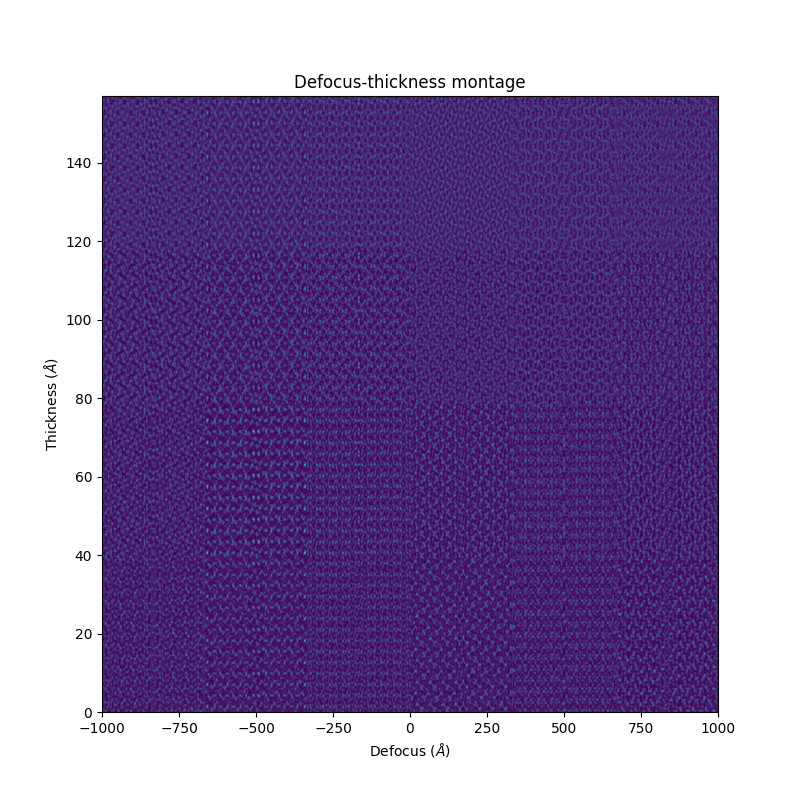

In [8]:
from pyms import aberration
thicknesses = np.arange(0,21,5)
nthick = len(thicknesses)
probe = pyms.plane_wave_illumination(gridpixels,gridsize,eV)

probes = []
for i,n in enumerate(np.diff(thicknesses)):
    probe = pyms.multislice(probe,n,P,T,tiling,output_to_bandwidth_limit=False)
    probes.append(probe)

# Settings for an uncorrected microscope 
Cs = 1.2e7
df = pyms.Scherzer_defocus(Cs,eV)

#Settings for a corrected microscope
Cs =0.0
ndf = 6
df = np.linspace(-1000,1000,num=ndf)

aberrations = []
aberrations.append(aberration("C10", "C1", "Defocus          ", 0.0, 0.0, 1, 0))
aberrations.append(aberration("C12", "A1", "2-Fold astig.    ", 0.0, 0.0, 1, 2))
aberrations.append(aberration("C23", "A2", "3-Fold astig.    ", 0.0, 0.0, 2, 3))
aberrations.append(aberration("C21", "B2", "Axial coma       ", 0.0, 0.0, 2, 1))
aberrations.append(aberration("C30", "C3", "3rd order spher. ", Cs, 0.0, 3, 0))

# Objective aperture in mrad, often this is not used in experiment
obj_app = 30
obj_app = None

# blur
sigma = 0.2
gauss = pyms.utils.Gaussian(sigma,gridpixels,gridsize)


CTF = [pyms.make_contrast_transfer_function(gridpixels,gridsize,eV,obj_app,aberrations=aberrations,df=d) for d in df]


fig,ax = plt.subplots(figsize=(8,8))
s1,s2 = probes[0].shape
montage = np.zeros((s1*(nthick-1),s2*ndf))
for idf in range(ndf):
    for ithick in range(nthick-1):
        img = np.abs(np.fft.ifft2(np.fft.fft2(probes[ithick])*np.fft.fft2(gauss)*CTF[idf]))**2
        montage[ithick*s1:(ithick+1)*s1,idf*s2:(idf+1)*s2] = img
ax.imshow(montage,extent=(df[0],df[-1],0,thicknesses[-1]*structure.unitcell[2]),aspect=np.ptp(df)/thicknesses[-1]/structure.unitcell[2])
ax.set_title('Defocus-thickness montage')
ax.set_ylabel('Thickness ($\AA$)')
ax.set_xlabel('Defocus ($\AA$)')


To simulate a diffraction pattern all we need to do is perform a Fourier transform of our exit surface wave.

Making projected potentials: 100%|████████████████| 5/5 [00:00<00:00, 23.38it/s]


Text(0.5, 1.0, 'Diffraction pattern')

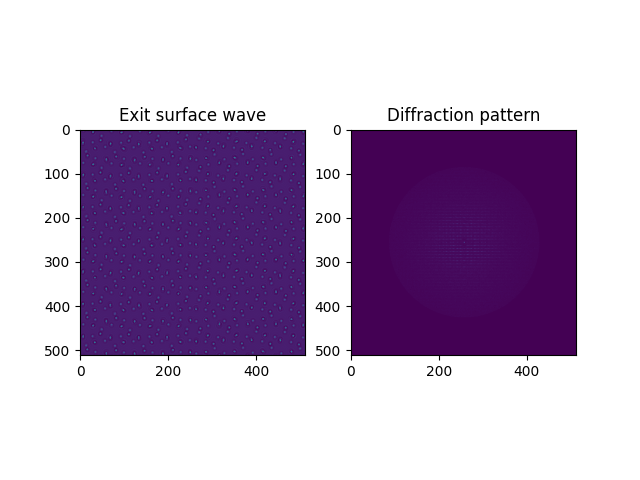

In [8]:
nslices = 5
P,T = pyms.multislice_precursor(structure,gridpixels[:2],eV,subslices=slices,tiling=tiling)
illum = pyms.plane_wave_illumination(gridpixels,gridsize,eV)
probe = pyms.multislice(illum,nslices,P,T,tiling,output_to_bandwidth_limit=False)

fig,ax = plt.subplots(ncols=2)
ax[0].imshow(np.abs(probe)**2)
ax[0].set_title("Exit surface wave")

# We use a sqrt function instead of abs **2 to visualize the diffraction pattern - this is not directly what we'd
# use in experiment but helps visualize weak features of the diffraction pattern
ax[1].imshow(np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(probe)))))
ax[1].set_title('Diffraction pattern')



If you are  working with burgonite, we can try some in-silico "selected area" electron diffraction to probe the two domains of either side of the domain wall.

Text(0.5, 1.0, 'Diffraction pattern')

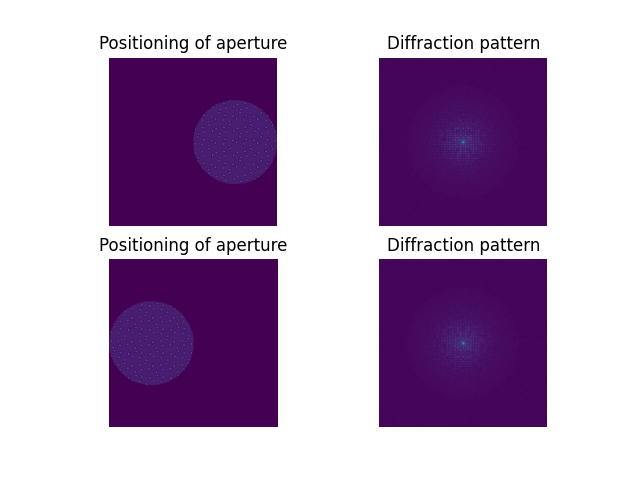

In [9]:
fig,ax = plt.subplots(ncols=2,nrows=2)
for a in ax.ravel():
    a.set_axis_off()

x,y = gridpixels[:2]
# Make the selected area aperture, which is just a circle function, with a diameter half that of the grid
d = x/2
selected_area_aperture = (np.arange(-x//2,x//2)**2)[None,:]+(np.arange(-y//2,y//2)**2)[:,None]< (d/2)**2

# Move the selected area aperture to one side of the domain wall
selected_area_aperture = np.roll(selected_area_aperture,y//4,axis=1)


ax[0,0].imshow(selected_area_aperture*np.abs(probe)**2)
ax[0,0].set_title('Positioning of aperture')
ax[0,1].imshow(np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(selected_area_aperture*probe)))))
ax[0,1].set_title('Diffraction pattern')


# Now move the selected area aperture to the other side of the domain wall
selected_area_aperture = np.roll(selected_area_aperture,-2*y//4,axis=1)
ax[1,0].imshow(selected_area_aperture*np.abs(probe)**2)
ax[1,0].set_title('Positioning of aperture')
ax[1,1].imshow(np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(selected_area_aperture*probe)))))
ax[1,1].set_title('Diffraction pattern')

The use of our in-silico "selected area diffration aperture" made these diffraction patterns look much more appealing and realistic, why would this be?

## STEM

For various reasons that should become clear soon scanning transmission electron microscopy (STEM) is the preferred approach for analysis at the Ångstrom scale so let's take a look at that...

First let's create a probe that we can scan in x and y

FloatSlider(value=0.0, description='X:', max=512.0)

FloatSlider(value=0.0, description='Y:', max=512.0)

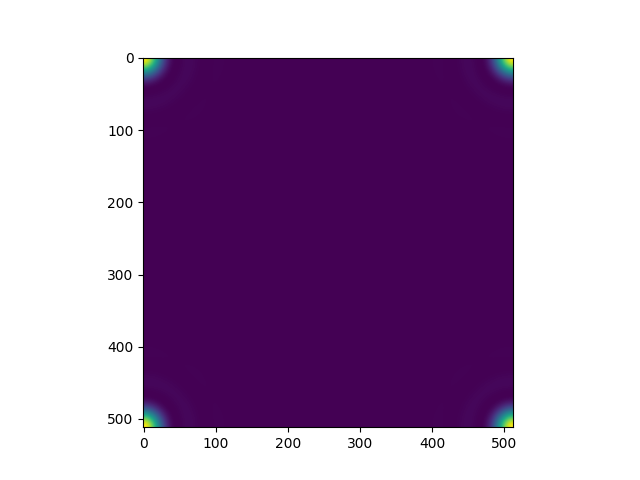

In [10]:
# Probe forming aperture
app = 2
probe = pyms.focused_probe(gridpixels,gridsize,eV,app)

# make plots
fig,ax = plt.subplots()
im = ax.imshow(np.abs(probe)**2)

def update_position(change):
    """Function to update plot when slider changes"""
    # Get the new X and Y values from the sliders
    x = slider_x.value
    y = slider_y.value
    im.set_data(np.abs(pyms.fourier_shift(probe,[y,x]))**2)

# Create the X position slider
slider_x = widgets.FloatSlider(value=0.0, min=0.0, max=gridpixels[1], step=0.1, description='X:')

# Create the Y position slider
slider_y = widgets.FloatSlider(value=0.0, min=0.0, max=gridpixels[0], step=0.1, description='Y:')

# Connect sliders to update function
slider_x.observe(update_position, names='value')
slider_y.observe(update_position, names='value')

#Display sliders
display(slider_x)
display(slider_y)

Now with multislice

Making projected potentials: 100%|████████████████| 5/5 [00:00<00:00, 23.33it/s]


FloatSlider(value=0.0, description='X:', max=512.0)

FloatSlider(value=0.0, description='Y:', max=512.0)

IntSlider(value=1, description='Z (slices):', min=1)

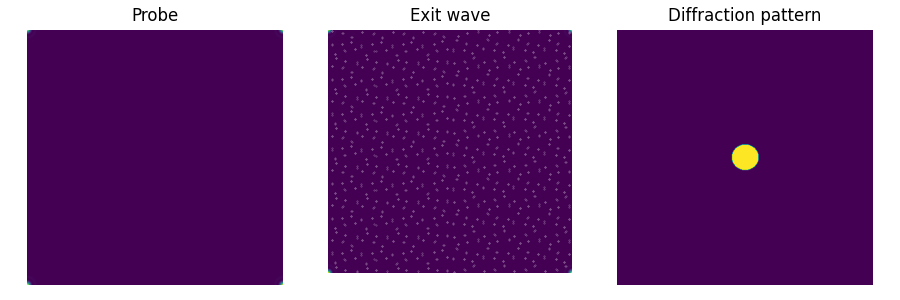

In [11]:
# Probe forming aperture in mrad, try 2, 10 and 30
app = 8
probe = pyms.focused_probe(gridpixels,gridsize,eV,app)

# Make propagators and transmission functions using convenience functions
P,T = pyms.multislice_precursor(structure,gridpixels[:2],eV,subslices=slices,tiling=tiling)

# make plots
fig,ax = plt.subplots(ncols=3,figsize=(9,3))
for a in ax:
    a.set_axis_off()
im1 = ax[0].imshow(np.abs(probe)**2)
ax[0].set_title('Probe')
im2 = ax[1].imshow(np.abs(probe)**2)
ax[1].set_title('Exit wave')

# It will be instructive to plot the positions of the atoms on the map of the probe exit
# wave, however if this becomes bothersome, comment out the next two lines
atoms = deepcopy(structure).tile(*tiling,1).atoms[:,:2]*np.asarray(gridpixels)
ax[1].plot(atoms[:,1],atoms[:,0],'wo',markersize=0.3,alpha=0.4)

im3 = ax[2].imshow(np.abs(np.fft.fftshift(np.fft.fft2(probe)))**2)
ax[2].set_title('Diffraction pattern')

fig.tight_layout()

def update_position(change):
    """Function to update probe and multislice when slider is changed"""
    # Get the new X, Y and Z values from the sliders
    x = slider_x.value
    y = slider_y.value
    z=  slider_z.value
    
    # Move the probe to the requested scan position
    exit_wave = pyms.fourier_shift(probe,[y,x])
    # Plot it in the first column
    im1.set_data(np.abs(exit_wave)**2)
    
    #
    exit_wave = pyms.multislice(exit_wave,z,P,T)
    DP = np.fft.fftshift(np.abs(np.fft.fft2(exit_wave))**2)
    im3.set_data(DP)
    im3.set_clim(vmin = DP.min(),vmax=DP.max())
    
    exit_wave = np.abs(exit_wave)**2
    im2.set_data(exit_wave)
    im2.set_clim(vmin = exit_wave.min(),vmax=exit_wave.max())
    

# Create the X position slider
slider_x = widgets.FloatSlider(value=0.0, min=0.0, max=gridpixels[1], step=0.1, description='X:')

# Create the Y position slider
slider_y = widgets.FloatSlider(value=0.0, min=0.0, max=gridpixels[0], step=0.1, description='Y:')
slider_z = widgets.IntSlider(value=1, min=1, max=100, step=1, description='Z (slices):')

slider_x.observe(update_position, names='value')
slider_y.observe(update_position, names='value')
slider_z.observe(update_position, names='value')
display(slider_x)
display(slider_y)

display(slider_z)

Note how the electron beam interacts with the sample in real space (the exit wave), can you intuit a correlation with diffraction space?

A lot of interesting information about the sample and how it scatters the electron beam here but how to make use of it? those familiar with STEM will know the most common approach is to use a monolithic circular and annular diffraction plane detectors use the signal intercepted by these to create images as the probe is scanned.

Note that the next cell is quite computationally intensive, you might want to jump back to cell 1 and change the sample to silicon 

Calculating datacube
Radially averaging diffraction patterns


IntRangeSlider(value=(0, 7), description='Detector range (mrad):', max=50)

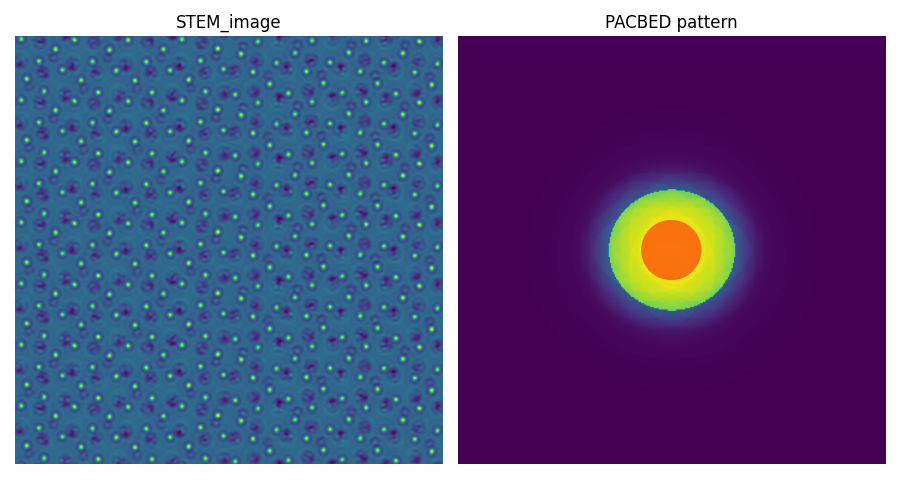

In [12]:
# Probe forming aperture in mrad, try 2, 10 and 30 though the larger this number is the slower the calculation will
# be
app = 15
# Thickness in Angstrom
thick = 100
probe = pyms.focused_probe(gridpixels,gridsize,eV,app)

# STEM multislice convenience function, if FourD_STEM is set to True then this will just output a diffraction
# pattern for every scan position of the probe
print('Calculating datacube')
datacube = pyms.STEM_multislice(structure,gridpixels,eV,app,thick,tiling=tiling,nfph=1,FourD_STEM=True,showProgress=False)['datacube']

# Calculate the position-averaged convergent beam electron diffraction (PACBED) pattern by summing
# over the datacube axes for probe position, we will use this to plot the detector on.
pacbed = np.sum(datacube,axis=(0,1))

#TODO radially average diffraction pattern to make live calculation much faster
print('Radially averaging diffraction patterns')
mradmax = int(pyms.max_grid_resolution(gridpixels,gridsize,eV=eV))
radial_average = np.zeros(datacube.shape[:2]+(mradmax,))
for i in range(mradmax):
    det = pyms.crop_to_bandwidth_limit(pyms.make_detector(gridpixels,gridsize,eV,i+1,i))
    radial_average[:,:,i] = np.sum(np.fft.ifftshift(det)*datacube,axis=(-2,-1))
#datacube = np.fft.ifftshift(datacube,axes=[-2,-1])

# Make some figures
fig,ax = plt.subplots(ncols=2,figsize=(9,5))
for a in ax:
    # Turn the 
    a.set_axis_off()

# Pixel size of the diffraction patterns
mradperpixel = pyms.diffraction_plane_pixel_size(gridpixels,gridsize,eV)

#
det = pyms.crop_to_bandwidth_limit(pyms.make_detector(gridpixels,gridsize,eV,app/2,0))
    
# Function to make STEM images from the datacube
def make_STEM_img(mradmin,mradmax):
    #det = pyms.crop_to_bandwidth_limit(pyms.make_detector(gridpixels,gridsize,eV,mradmax,mradmin))
    #img = np.sum(det*datacube,axis=(-2,-1))
    img = np.sum(radial_average[...,mradmin:mradmax],axis=-1)
    # Why do we need to tile and interpolate the image? 
    # HINT short-circuit this step by uncommenting the next line
    # return img
    return pyms.utils.fourier_interpolate(np.tile(img,tiling),gridpixels)

# Plot the initial STEM image
stem_img = ax[0].imshow(make_STEM_img(0,int(app/2)))
ax[0].set_title('STEM_image')
pcbed = ax[1].imshow(pacbed)

# Plot a detector
from matplotlib.patches import Annulus
detector = Annulus([x//2 for x in pacbed.shape], app/2/mradperpixel[0], app/2/mradperpixel[0]-0.1, angle=0.0, alpha=0.5,fc='r')
ax[1].add_patch(detector)
ax[1].set_title('PACBED pattern')



fig.tight_layout()
def update(change):
    # Get the new X, Y and Z values from the sliders
    mradmin,mradmax = slider.value
    
    img = make_STEM_img(mradmin,mradmax)
    stem_img.set_data(img)
    stem_img.set_clim(img.min(),img.max())

    detector.set_radii(mradmax/mradperpixel[0])
    detector.set_width(min(mradmax/mradperpixel[0]-mradmin/mradperpixel[0],mradmax/mradperpixel[0]-0.01))

# Create the detector range slider
mradmax = pyms.max_grid_resolution(gridpixels,gridsize,eV=eV)
slider = widgets.IntRangeSlider(value=[0,app//2], min=0, max=int(mradmax), description="Detector range (mrad):")
slider.observe(update)
display(slider)

With the ability to record 4D-STEM datasets we have many more options than just using annular detectors to integrate monolithic regions of the diffraction pattern. Differential phase contrast (DPC) STEM is an approach were we calculate the centre of mass of the diffraction pattern. It can be shown that this quantity is proportional to the electric field (which is the gradient of the electro static potential). A simplified description of DPC often has the STEM bright field disk being deflected in response to electric fields within the sample:

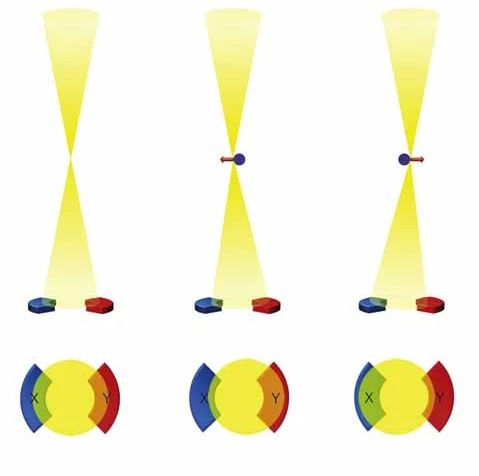

Let's see how a STEM diffraction pattern responds to some simplified electro-static potentials

[240, 251]


FloatSlider(value=0.0, description='X:', max=512.0)

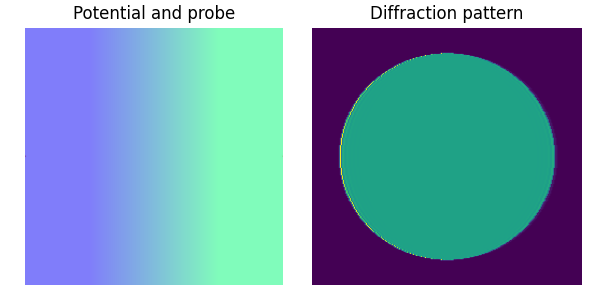

In [13]:
# Probe forming aperture in mrad, try 2, 10 and 30
app = 30
probe = pyms.focused_probe(gridpixels,gridsize,eV,app)
shifted_probe = pyms.fourier_shift(probe,[gridpixels[0]//2,0])
d =2

# Make transmission function
# Ramp function (ie. approximation of a magnetic domain or p-n junction)
def ramp_function(x,d):
    if x<0.5-1/2/d:
        return 0
    if x>=0.5-1/2/d and x<= 0.5+1/2/d:
        return d*(x-0.5+1/2/d)
    else:
        return 1
potential = np.asarray([ramp_function(x,d) for x in np.arange(gridpixels[1])/gridpixels[1]])

# Gaussian function
sigma = 100
#potential = np.exp(-(np.arange(gridpixels[1])-gridpixels[1]//2)**2/sigma**2)

# Step function (foil edge, heterostructure interface maybe?)
def step_function(x):
    if x<0.5:
        return 0
    else:
        return 1
#potential = np.asarray([step_function(x) for x in np.arange(gridpixels[1])/gridpixels[1]])/2

potential = 2*np.pi*np.broadcast_to(potential,gridpixels[:2])
T = np.exp(1j*potential)


# make plots
fig,ax = plt.subplots(ncols=2,figsize=(6,3))
for a in ax:
    a.set_axis_off()




ax[0].set_title('Potential and probe')

probeplot = ax[0].imshow(np.abs(shifted_probe)**2,cmap=plt.get_cmap('Reds'),alpha=0.5)
potplot = ax[0].imshow(potential,cmap=plt.get_cmap('winter'),alpha=0.5)


# Pixel size of the diffraction patterns
mradperpixel = pyms.diffraction_plane_pixel_size(gridpixels,gridsize[:2],eV)
cropwindow = [int(2.5*app/x) for x in mradperpixel]
print(cropwindow)

DP = np.abs(np.fft.fftshift(np.fft.fft2(shifted_probe*T)))**2
DPplot = ax[1].imshow(pyms.utils.crop(DP,cropwindow))
ax[1].set_title('Diffraction pattern')

fig.tight_layout()

def update_position(change):
    """Function to update probe and multislice when slider is changed"""
    # Get the new X, Y and Z values from the sliders
    x = slider_x.value
    y = gridpixels[0]//2
    
    # Move the probe to the requested scan position
    exit_wave = pyms.fourier_shift(probe,[y,x])
    # Plot it in the first column
    probeplot.set_data(np.abs(exit_wave)**2)
    
    #
    exit_wave = exit_wave*T
    DP = np.fft.fftshift(np.abs(np.fft.fft2(exit_wave))**2)
    DPplot.set_data(pyms.utils.crop(DP,cropwindow))
    DPplot.set_clim(vmin = DP.min(),vmax=DP.max())
    

# Create the X position slider
slider_x = widgets.FloatSlider(value=0.0, min=0.0, max=gridpixels[1], step=0.1, description='X:')


slider_x.observe(update_position, names='value')
display(slider_x)